In [2]:
import pandas as pd
import numpy as np
import osmnx as ox
import datetime
import seaborn as sn
from shapely import wkb
from shapely.geometry import Point
from shapely.geometry import LineString
import geopandas as gp
import matplotlib.pyplot as plt
import random, string
from scipy.spatial.distance import cdist
import os, sys
%matplotlib inline
from collections import deque
import networkx as nx
from time import sleep
from copy import deepcopy
from sympy import Matrix, init_printing
import pickle
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import johnson

In [38]:
matches = pd.read_csv('./data/mr.csv', sep=';', index_col='id', engine='python')
matches = matches[matches.cpath.isnull()]
# matches['tt'] = matches['ep'].apply(lambda x: np.array([float(e) for e in x.split(',')])) * \
# matches['tp'].apply(lambda x: np.array([float(e) for e in x.split(',')]))
# matches['error'] = matches['error'].apply(lambda x: [float(x) for x in x.split(',')])
# matches['match'] = matches['error'].apply(lambda x: True if all(y<0.00001 for y in x) else False)
# matches = matches[matches['match']]
# data = pd.read_parquet('./test/data-test/gps-data/part-00000-498c167d-fb29-4098-a9f9-682631b98b93-c000.snappy')
# trajectories = gp.read_file('./test/data-test/trajectories/trajs.shp')
# trajectories.set_index('id', drop=True, inplace=True)

In [37]:
data[(data.route_slug=='8JhUrHp24Z')]

accuracy   altitude    bearing  \
20         5.570  1332.7999  150.00919   
21         6.452  1339.2000  155.57620   
22         5.500  1339.2000  150.00919   
23         9.630  1339.2000  155.57620   
263240     4.500  1333.0000  268.77954   
263241     4.666  1333.0000  268.77954   
263242     4.916  1331.0000  268.77954   
263243     4.833  1332.0000  268.77954   
263244     4.600  1333.0000  268.77954   

                                          location  route_slug      speed  \
20      0101000000B404190115B2494012143FC6DCDD4140  8JhUrHp24Z   8.292407   
21      0101000000C9737D1F0EB24940CCB8A981E6DD4140  8JhUrHp24Z   4.542053   
22      0101000000C1E61C3C13B24940EDD5C743DFDD4140  8JhUrHp24Z   7.536936   
23      01010000009A232BBF0CB24940350708E6E8DD4140  8JhUrHp24Z   3.575028   
263240  01010000007D7901F6D1B54940D23AAA9A20DE4140  8JhUrHp24Z  52.165651   
263241  0101000000598638D6C5B5494060C77F8120DE4140  8JhUrHp24Z  37.019250   
263242  01010000003EEC8502B6B549409CF9D51C20DE4140  8JhUrHp24Z  31.401497   
263243  0101000000A9BF5E61C1B549401FD8F15F20DE4140  8JhUrHp24Z  23.581377   
263244  0101000000FED2A23EC9B5494060C77F8120DE4140  8JhUrHp24Z  43.225668   

            timestamp          dest_session  \
20      1595156104461  oRubduh1q8Jdurs9PvqZ   
21      1595156100423  oRubduh1q8Jdurs9PvqZ   
22      1595156103451  oRubduh1q8Jdurs9PvqZ   
23      1595156099417  oRubduh1q8Jdurs9PvqZ   
263240  1595156608701  oRubduh1q8Jdurs9PvqZ   
263241  1595156611720  oRubduh1q8Jdurs9PvqZ   
263242  1595156617756  oRubduh1q8Jdurs9PvqZ   
263243  1595156613728  oRubduh1q8Jdurs9PvqZ   
263244  1595156610716  oRubduh1q8Jdurs9PvqZ   

                                   device_id     way_id  dir  
20      927ff2a8-6a81-4131-9210-645f84a9c0b7  149142534    0  
21      927ff2a8-6a81-4131-9210-645f84a9c0b7  149142534    0  
22      927ff2a8-6a81-4131-9210-645f84a9c0b7  149142534    0  
23      927ff2a8-6a81-4131-9210-645f84a9c0b7  149142534    0  
263240  927ff2a8-6a81-4131-9210-645f84a9c0b7  320776725    0  
263241  927ff2a8-6a81-4131-9210-645f84a9c0b7  320776725    0  
263242  927ff2a8-6a81-4131-9210-645f84a9c0b7  320776725    0  
263243  927ff2a8-6a81-4131-9210-645f84a9c0b7  320776725    0  
263244  927ff2a8-6a81-4131-9210-645f84a9c0b7  320776725    0

In [33]:
data[:30]

accuracy   altitude     bearing  \
0      3.900  1356.0000   90.780136   
1      3.900  1356.0000   91.925960   
2      3.900  1356.0000   85.699320   
3      3.900  1346.0000   35.111763   
4      3.900  1348.0000   36.333157   
5     21.689  1292.4620   25.564777   
6     22.624  1295.1461   25.564777   
7     21.322  1291.4889   11.989945   
8     20.899  1291.7589   11.989945   
9     22.624  1295.1461   25.564777   
10     4.100  1122.5000  261.979060   
11     4.075  1122.6000  261.979060   
12     3.966  1122.8000  261.979060   
13     4.050  1122.5000  261.979060   
14     4.100  1122.5000  261.979060   
15    16.000  1107.5048  261.979060   
16    16.000  1107.5048  261.979060   
17    16.000  1106.9369  261.979060   
18    15.333  1106.9963  261.979060   
19    16.000  1106.9369  261.979060   
20     5.570  1332.7999  150.009190   
21     6.452  1339.2000  155.576200   
22     5.500  1339.2000  150.009190   
23     9.630  1339.2000  155.576200   
24     4.824  1249.7999  215.817210   
25     3.710  1249.7999  215.703550   
26     3.900  1249.7999  224.015750   
27     4.747  1249.7999  215.703550   
28     4.747  1249.7999  215.703550   
29     4.005  1251.7000  224.015750   

                                      location  route_slug      speed  \
0   010100000055850662D9AC4940D7C1C1DEC4DE4140  JNC0SAC9GU  52.600954   
1   01010000009C14E63DCEAC494089247A19C5DE4140  JNC0SAC9GU  49.290246   
2   01010000001FA2D11DC4AC494018B14F00C5DE4140  JNC0SAC9GU  50.313168   
3   0101000000E6E8F17B9BAC4940ADC090D5ADDE4140  JNC0SAC9GU  43.134890   
4   01010000005358A9A0A2AC494026AAB706B6DE4140  JNC0SAC9GU  40.680306   
5   0101000000876C205D6CAC4940572250FD83DE4140  Mcpa0Gsdtx  58.987325   
6   010100000032AA0CE36EAC49402502D53F88DE4140  Mcpa0Gsdtx  53.269913   
7   01010000006BBB09BE69AC494066A032FE7DDE4140  Mcpa0Gsdtx  59.649948   
8   01010000007769C36169AC4940F660527C7CDE4140  Mcpa0Gsdtx  59.449446   
9   010100000026FC523F6FAC4940FB3A70CE88DE4140  Mcpa0Gsdtx  53.269913   
10  010100000079211D1EC2B44940F41ABB44F5D24140  k0RwAvJ1qO  10.027937   
11  010100000079211D1EC2B44940F41ABB44F5D24140  k0RwAvJ1qO  13.631573   
12  0101000000A8716F7EC3B44940A67D737FF5D24140  k0RwAvJ1qO  16.322118   
13  0101000000467C2766BDB44940EE5D83BEF4D24140  k0RwAvJ1qO  12.390730   
14  010100000079211D1EC2B44940F41ABB44F5D24140  k0RwAvJ1qO  10.027937   
15  0101000000DBF97E6ABCB44940AD6EF59CF4D24140  Dlqhq89Ci0  18.637668   
16  0101000000DBF97E6ABCB44940AD6EF59CF4D24140  Dlqhq89Ci0  18.637668   
17  0101000000DBF97E6ABCB44940AD6EF59CF4D24140  Dlqhq89Ci0  19.232024   
18  0101000000DBF97E6ABCB44940AD6EF59CF4D24140  Dlqhq89Ci0  29.608564   
19  0101000000DBF97E6ABCB44940AD6EF59CF4D24140  Dlqhq89Ci0  19.232024   
20  0101000000B404190115B2494012143FC6DCDD4140  8JhUrHp24Z   8.292407   
21  0101000000C9737D1F0EB24940CCB8A981E6DD4140  8JhUrHp24Z   4.542053   
22  0101000000C1E61C3C13B24940EDD5C743DFDD4140  8JhUrHp24Z   7.536936   
23  01010000009A232BBF0CB24940350708E6E8DD4140  8JhUrHp24Z   3.575028   
24  0101000000C9AB730CC8B6494015A930B610DC4140  0ke6SDJHxY   0.083690   
25  01010000009B8F6B43C5B64940D52137C30DDC4140  0ke6SDJHxY  18.788525   
26  010100000047B071FDBBB649407A51BB5F05DC4140  0ke6SDJHxY  27.419317   
27  0101000000C9AB730CC8B6494015A930B610DC4140  0ke6SDJHxY  13.487686   
28  0101000000C9AB730CC8B6494015A930B610DC4140  0ke6SDJHxY  13.487686   
29  0101000000ED647094BCB64940800EF3E505DC4140  TFyVa1Qq2k  15.392038   

        timestamp          dest_session                             device_id  \
0   1595146727096  6OsGWC41w4VIEQvCPvfe  82257919-5957-4fb8-b5ad-d64455691453   
1   1595146725074  6OsGWC41w4VIEQvCPvfe  82257919-5957-4fb8-b5ad-d64455691453   
2   1595146723051  6OsGWC41w4VIEQvCPvfe  82257919-5957-4fb8-b5ad-d64455691453   
3   1595146711485  6OsGWC41w4VIEQvCPvfe  82257919-5957-4fb8-b5ad-d64455691453   
4   1595146714998  6OsGWC41w4VIEQvCPvfe  82257919-5957-4fb8-b5ad-d64455691453   
5   1595133573291  BeP8oXZr6Pnm0x9AZMGs  39b

In [22]:
doubles = []
for index, row in matches.iterrows():
    if len(matches.loc[index].shape) > 1 and index not in doubles:
        doubles.append(index)
print(doubles)
print(len(doubles))
# matches.sort_index(inplace=True)

[0, 620, 2648, 2, 1238, 1784, 1495, 1194, 69, 622, 2137, 2750, 623, 2272, 1196, 2287, 2472, 352, 998, 2753, 626, 80, 3641, 1203, 879, 1204, 608, 2275, 629, 1756, 2019, 154, 2278, 561, 2440, 1207, 1650, 1943, 1758, 2281, 22, 1212, 2983, 635, 3643, 3240, 240, 637, 2081, 2289, 1762, 28, 639, 1370, 1882, 1171, 1967, 1567, 1763, 914, 641, 75, 3253, 2291, 537, 703, 1868, 598, 1924, 33, 426, 3193, 238, 1394, 646, 3590, 456, 2763, 3251, 1336, 2785, 651, 551, 2764, 3252, 407, 1254, 652, 2765, 2391, 40, 1771, 253, 753, 2748, 1231, 2307, 2829, 3708, 3255, 711, 821, 1233, 1234, 3712, 1155, 1235, 1774, 924, 1236, 48, 1873, 2201, 1237, 49, 1239, 51, 1390, 3718, 52, 449, 759, 1778, 480, 53, 171, 283, 607, 1242, 1780, 1088, 2413, 677, 415, 1244, 444, 3086, 57, 2320, 1781, 58, 3035, 2784, 681, 1783, 494, 152, 2327, 61, 687, 768, 688, 1252, 269, 1253, 3270, 197, 2666, 1789, 690, 1255, 1150, 1256, 692, 1257, 1260, 2333, 3111, 1837, 2880, 2798, 1403, 934, 71, 1293, 486, 72, 2540, 3742, 3280, 1803, 555, 12

In [23]:
doubles = []
for index, row in trajectories.iterrows():
    if len(trajectories.loc[index].shape) > 1 and index not in doubles:
        doubles.append(index)
print(doubles)
print(len(doubles))

[2, 8, 9, 15, 22, 28, 33, 40, 48, 49, 51, 52, 53, 57, 58, 61, 69, 71, 72, 75, 79, 80, 82, 83, 87, 99, 108, 110, 112, 119, 122, 123, 131, 134, 137, 142, 144, 146, 147, 149, 152, 153, 154, 157, 161, 163, 166, 170, 171, 172, 173, 174, 180, 184, 187, 189, 193, 194, 197, 198, 201, 211, 214, 215, 218, 219, 230, 236, 238, 240, 242, 243, 244, 245, 253, 257, 258, 260, 261, 267, 269, 270, 273, 275, 279, 282, 283, 294, 295, 296, 300, 304, 305, 307, 312, 315, 317, 320, 323, 327, 331, 332, 333, 335, 336, 337, 339, 340, 344, 346, 348, 350, 351, 352, 354, 356, 357, 359, 360, 362, 364, 365, 371, 373, 376, 377, 384, 390, 396, 398, 403, 404, 405, 407, 409, 410, 411, 412, 415, 416, 417, 419, 421, 422, 426, 436, 441, 443, 444, 449, 450, 453, 454, 455, 456, 462, 465, 470, 475, 476, 480, 482, 486, 492, 494, 497, 499, 500, 502, 504, 505, 514, 516, 534, 536, 537, 538, 551, 555, 559, 561, 565, 569, 570, 574, 577, 578, 580, 586, 588, 593, 598, 599, 600, 602, 603, 605, 606, 607, 608, 612, 618, 619, 620, 622, 623

In [29]:
# trajectories.loc[15]
767/4949

0.15498080420286928

In [111]:
a = trajectories.index == matches.index

In [114]:
a = []
for i in trajectories.index:
    if i not in matches.index:
        a.append(i)
print(a)

[6, 178, 179, 181, 182, 236, 236, 265, 345, 347, 417, 417, 418, 431, 437, 439, 440, 560, 562, 589, 592, 630, 631, 672, 676, 705, 757, 784, 785, 796, 807, 911, 923, 944, 945, 948, 949, 973, 1042, 1044, 1045, 1057, 1149, 1189, 1201, 1202, 1218, 1220, 1345, 1349, 1364, 1365, 1449, 1512, 1513, 1514, 1534, 1590, 1591, 1713, 1714, 1715, 1716, 1725, 1729, 1812, 1822, 1823, 1825, 1830, 1845, 1925, 1937, 1949, 1950, 2086, 2168, 2169, 2173, 2174, 2216, 2234, 2235, 2269, 2279, 2280, 2298, 2299, 2389, 2396, 2397, 2401, 2403, 2404, 2421, 2477, 2478, 2479, 2480, 2481, 2482, 2488, 2547, 2577, 2587, 2588, 2594, 2599, 2600, 2601, 2698, 2726, 2759, 2782, 2783, 2859, 2892, 2893, 2894, 2910, 2911, 2931, 2935, 2936, 3033, 3048, 3049, 3059, 3073, 3098, 3104, 3120, 3140, 3165, 3196, 3197, 3219, 3220, 3221, 3222, 3318, 3319, 3321, 3343, 3395, 3397, 3406, 3449, 3515, 3516, 3528, 3535, 3538, 3638, 3645, 3659, 3694, 3717, 3775, 3780, 3818, 3819, 3820, 3923, 3946, 3955, 3997, 4000, 4062, 4086, 4087, 4099, 4100]


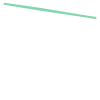

In [115]:
trajectories.loc[6].geometry

In [39]:
def geo_center(S, vertices):
    S = list(S)
    mean_point = np.mean(vertices[S], axis=0)
    dists = np.linalg.norm(vertices[S]-mean_point, axis=1)
    center = S[np.argmin(dists)]
    return center

def adjacent_vertex(S, adjacencies):
    out_vertices = set()
    for p in S:
        adjacents = set(np.where(adjacencies[p]==1)[0])
        complements = adjacents-S
        out_vertices = out_vertices.union(complements)
    return out_vertices

def compute_dist(point, seed, dists, predecessors):
    cobweb_dist = 0
    predecessor = predecessors[point]
    while point != seed:
        cobweb_dist += dists[point, predecessor]
        point = predecessor
        predecessor = predecessors[point]
    return cobweb_dist

In [40]:
trajectories = gp.read_file('./data/trajectories/trajs.shp')
trajectories = trajectories[trajectories.id.isin(matches.index)]
trajectories.reset_index(drop=True, inplace=True)
bearing_lens = trajectories['bearing'].apply(lambda x: len(x.split(',')))
coords_lens = trajectories['geometry'].apply(lambda x: np.array(x.coords).shape[0])
mis_aligns = np.where((bearing_lens == coords_lens) == False)[0]
trajectories = trajectories.drop(mis_aligns, axis=0)
trajectories.set_index('id', drop=True, inplace=True)

In [41]:
np.random.seed(123456)
bearings = np.concatenate(np.array(trajectories['bearing'].apply(lambda x: np.array(x.split(',')).astype(np.float))))
newarray = np.concatenate(np.array(trajectories['geometry'].apply(lambda x: np.array(x.coords))))
Rv = 0.0001
Pv = 10
V_set = []
B_set = []
while newarray.size > 0:
    rand_index = np.random.choice(newarray.shape[0], size=1, replace=False)
    rand_point, rand_bearing = newarray[rand_index][0], bearings[rand_index][0]
    V_set.append(rand_point)
    B_set.append(rand_bearing)
    dists = np.linalg.norm(newarray-rand_point, axis=1)
    angle_diffs = abs(bearings-rand_bearing)
    unmerge = (dists>Rv) | (angle_diffs>Pv)
    newarray = newarray[unmerge]
    bearings = bearings[unmerge]
V_set = np.vstack(V_set)

Rc = 0.00095
Pc = 45
dists = cdist(V_set, V_set)
B_set = np.array([B_set]*len(B_set))
adiffs = abs(B_set-B_set.T)
# adj_matrix = np.ma.getmask(np.ma.masked_where(dists<Rc, dists)).astype(np.int)
# dists_mask = (dists<Rc).astype(np.int)
# adiffs_mask = (adiffs<Pc).astype(np.int)
adj_matrix = ((dists<Rc)*(adiffs<Pc)).astype(np.int)
np.fill_diagonal(adj_matrix, 0)

cobweb_graph = csr_matrix(dists*adj_matrix)
cobweb_dists, cobweb_pre = johnson(csgraph=cobweb_graph, directed=False, return_predecessors=True)

r = 0.00085
delta = 4
indices = np.arange(0, V_set.shape[0], 1)
all_marked = set()
all_nodes = set(range(V_set.shape[0]))
random_choices = []
predecessors = {}

while all_nodes != all_marked:
    s = np.random.choice(indices[~np.isin(indices, random_choices)])
    random_choices.append(s)
    Q_g = deque()
    Q_g.appendleft(s)
    Q_l = deque()
    # eddited on the original algorithm
    Q_l.appendleft(s)
    distances = deque()
    distances.appendleft(0)
    count = 0
    S = set()
    marks = np.zeros((V_set.shape[0]), np.int)


#     graph_dict = {'marks':marks, 'S':S, 'graph_adj':adj_matrix, 'indices':indices, 'seed':V_set[s]}
#     with open('/home/peyman/Documents/projects/balad/codes/cobweb/graph.pkl', 'wb') as graph_file:
#         pickle.dump(graph_dict, graph_file)
#     sleep(2)
    
    marks[s] = 1
    S.add(s)
    print(f'set S is: {S}')

    while len(Q_g) != 0:
        print(f'Q_g currently is: {Q_g}')
        print(f'Q_l currently is: {Q_l}')
        seed = Q_g.pop()
        predecessors[seed] = seed
        print(f'node {seed} choosed as seed')
        print(f'adjacent nodes to seed {seed} are {np.where(adj_matrix[seed]==1)[0]}')
        for p in np.where(adj_matrix[seed]==1)[0]:
            if marks[p] != 1:
                print(f'node {p} accepted as adjacent to seed {seed} and it is unmarked')
                marks[p] = 1
                Q_l.appendleft(p)
                print(f'node {p} marked and appended to Q_l')
                predecessors[p] = seed
                distances.appendleft(compute_dist(p, seed, dists, predecessors))
            else:
                print(f'node {p} accepted as adjacent to seed {seed} but it is marked')
        print(f'adjcent nodes to seed {seed} all appended to Q_l. Now Q_l is : {Q_l}')
        while len(Q_l) != 0:
            p = Q_l.pop()
            print(f'node {p} poped from Q_l')
            temp_dist = distances.pop()
            if temp_dist < r:
                print(f'distance from node {p} to seed {seed} is: {temp_dist} below the threshold {r}') 
                count += 1
                S.add(p)
                print(f'node {p} added to set S. Now S is: {S}')
                print(f'adjacent nodes to {p} are {np.where(adj_matrix[p]==1)[0]}')
                for p_prime in np.where(adj_matrix[p]==1)[0]:
                    if marks[p_prime] != 1:
                        print(f'node {p_prime} accepted as adjacent to {p} and it is unmarked')
                        marks[p_prime] = 1
                        Q_l.appendleft(p_prime)
                        print(f'node {p_prime} marked and appended to Q_l')
                        predecessors[p_prime] = p
                        distances.appendleft(compute_dist(p_prime, seed, dists, predecessors))
                    else:
                        print(f'node {p_prime} accepted as adjacent to {p} but it is marked')
                print(f'adjcent nodes to {p} all appended to Q_l. Now Q_l is : {Q_l}')
                
#                 graph_dict = {'marks':marks, 'S':S, 'graph_adj':adj_matrix, 'indices':indices, 'seed':V_set[seed]}
#                 with open('/home/peyman/Documents/projects/balad/codes/cobweb/graph.pkl', 'wb') as graph_file:
#                     pickle.dump(graph_dict, graph_file)
#                 sleep(0.5)

            else:
                print(f'distance from node {p} to seed {seed} is: {temp_dist} above the threshold {r}') 
                if count > delta:
                    print(f'number of nodes in S are: {count} above the threshold {delta}')
                    Vc = geo_center(S, V_set)
                    print(f'node {Vc} choosed as the geocenter node')
                    V_prime = adjacent_vertex(S, adj_matrix)
                    print(f'nodes {V_prime} are out of S')
                    ommited = list(S-{Vc})
                    print(f'nodes {ommited} ommited from V except geocenter {Vc}')
                    indices = indices[~np.isin(indices, ommited)]
                    adj_matrix[:, ommited] = 0
                    adj_matrix[ommited] = 0
                    for v in V_prime:
                        Q_g.appendleft(v)
                        print(f'node {v} from V_prime appended to Q_g')
                        adj_matrix[v, Vc] = 1
                        adj_matrix[Vc, v] = 1
                    count = 0
                    S = set()
                    print('set S got empty')
                else:
                    print(f'number of nodes in S are: {count} below the threshold {delta}')

#                 graph_dict = {'marks':marks, 'S':S, 'graph_adj':adj_matrix, 'indices':indices, 'seed':V_set[seed]}
#                 with open('/home/peyman/Documents/projects/balad/codes/cobweb/graph.pkl', 'wb') as graph_file:
#                     pickle.dump(graph_dict, graph_file)
#                 sleep(0.5)

                # eddited on the original algorithm
                all_marked = all_marked.union(set(np.where(marks==1)[0]))
                while len(Q_l) != 0:
                    p = Q_l.pop()
                    print(f'node {p} poped from Q_l and unmarked')
                    marks[p] = 0
                distances.clear()
                
            all_marked = all_marked.union(set(np.where(marks==1)[0]))
            print('*'*50)
        
        # eddited on the original algorithm
        count = 0
        S = set()
        predecessors = {}
        
    
    all_marked = all_marked.union(set(np.where(marks==1)[0]))
    print(f'{"="*60} all marked are: {all_marked}')
    print(f'{"="*60} all nodes: {all_nodes}')
    print(f'{"="*60} random choices for s: {random_choices}')
    
    
rtree_graph = csr_matrix(dists*adj_matrix)
rtree_dists, rtree_pre = johnson(csgraph=rtree_graph, directed=False, return_predecessors=True)

a = deepcopy(adj_matrix)
theta_c = 0.003
theta_t = 0.002
for i in indices:
    for j in indices:
        if cobweb_dists[i, j] <= theta_c and rtree_dists[i, j] >= theta_t:
            adj_matrix[i, j] = 1

graph_dict = {'marks':marks, 'S':S, 'graph_adj':adj_matrix, 'indices':indices, 'seed':V_set[seed]}
with open('/home/peyman/Documents/projects/balad/codes/cobweb/graph.pkl', 'wb') as graph_file:
    pickle.dump(graph_dict, graph_file)

set S is: {554}
Q_g currently is: deque([554])
Q_l currently is: deque([554])
node 554 choosed as seed
adjacent nodes to seed 554 are [ 81  93 131 155 197 259 323 329 342 407 503 619 943]
node 81 accepted as adjacent to seed 554 and it is unmarked
node 81 marked and appended to Q_l
node 93 accepted as adjacent to seed 554 and it is unmarked
node 93 marked and appended to Q_l
node 131 accepted as adjacent to seed 554 and it is unmarked
node 131 marked and appended to Q_l
node 155 accepted as adjacent to seed 554 and it is unmarked
node 155 marked and appended to Q_l
node 197 accepted as adjacent to seed 554 and it is unmarked
node 197 marked and appended to Q_l
node 259 accepted as adjacent to seed 554 and it is unmarked
node 259 marked and appended to Q_l
node 323 accepted as adjacent to seed 554 and it is unmarked
node 323 marked and appended to Q_l
node 329 accepted as adjacent to seed 554 and it is unmarked
node 329 marked and appended to Q_l
node 342 accepted as adjacent to seed 55

**************************************************
node 747 poped from Q_l
distance from node 747 to seed 445 is: 0.0006760687834837533 below the threshold 0.00085
node 747 added to set S. Now S is: {641, 674, 453, 166, 747, 556, 370, 564, 280, 572}
adjacent nodes to 747 are [ 84 123 266 284 321 345 370 377 441 445 453 469 481 556 564 641 674 683
 828]
node 84 accepted as adjacent to 747 but it is marked
node 123 accepted as adjacent to 747 but it is marked
node 266 accepted as adjacent to 747 but it is marked
node 284 accepted as adjacent to 747 but it is marked
node 321 accepted as adjacent to 747 and it is unmarked
node 321 marked and appended to Q_l
node 345 accepted as adjacent to 747 but it is marked
node 370 accepted as adjacent to 747 but it is marked
node 377 accepted as adjacent to 747 and it is unmarked
node 377 marked and appended to Q_l
node 441 accepted as adjacent to 747 and it is unmarked
node 441 marked and appended to Q_l
node 445 accepted as adjacent to 747 but it is

**************************************************
node 472 poped from Q_l
distance from node 472 to seed 642 is: 0.00046387067162423747 below the threshold 0.00085
node 472 added to set S. Now S is: {64, 324, 264, 461, 143, 472, 154, 60, 189}
adjacent nodes to 472 are [ 60  64 109 143 154 167 189 264 276 324 335 461 476 498 511 610 642 682
 763 792 838 944]
node 60 accepted as adjacent to 472 but it is marked
node 64 accepted as adjacent to 472 but it is marked
node 109 accepted as adjacent to 472 but it is marked
node 143 accepted as adjacent to 472 but it is marked
node 154 accepted as adjacent to 472 but it is marked
node 167 accepted as adjacent to 472 but it is marked
node 189 accepted as adjacent to 472 but it is marked
node 264 accepted as adjacent to 472 but it is marked
node 276 accepted as adjacent to 472 but it is marked
node 324 accepted as adjacent to 472 but it is marked
node 335 accepted as adjacent to 472 but it is marked
node 461 accepted as adjacent to 472 but it is 

**************************************************
Q_g currently is: deque([511, 254, 317, 763, 633, 882, 682, 616, 165, 163, 98, 610, 930, 993, 90, 472, 278, 276, 335, 139, 138, 584, 838, 642, 255, 514, 699, 378, 309, 944, 557, 42, 551, 100, 483, 608, 606, 797, 536, 472, 470, 402, 18, 399, 206, 458, 328, 8, 647, 838, 511, 763, 633, 882, 881, 238, 740, 610, 98, 865, 862, 472, 335, 584, 317, 561, 176, 815, 682, 165, 163, 930, 792, 278, 276, 651, 138, 514, 504, 758, 566, 821, 689, 612, 418, 349, 283, 25, 80, 907, 839, 198, 452, 127, 252, 635, 1016, 500, 752, 632, 108, 553, 297, 935, 604, 730, 661, 334, 454, 513, 511, 763, 881, 113, 365, 109, 100, 483, 610, 865, 862, 221, 90, 335, 838, 315, 440, 51, 944, 174, 682, 167])
Q_l currently is: deque([])
node 167 choosed as seed
adjacent nodes to seed 167 are []
adjcent nodes to seed 167 all appended to Q_l. Now Q_l is : deque([])
Q_g currently is: deque([511, 254, 317, 763, 633, 882, 682, 616, 165, 163, 98, 610, 930, 993, 90, 472, 278, 276, 335

node 335 accepted as adjacent to seed 511 but it is marked
node 472 accepted as adjacent to seed 511 but it is marked
node 514 accepted as adjacent to seed 511 but it is marked
node 610 accepted as adjacent to seed 511 but it is marked
node 642 accepted as adjacent to seed 511 but it is marked
node 682 accepted as adjacent to seed 511 but it is marked
node 763 accepted as adjacent to seed 511 but it is marked
node 862 accepted as adjacent to seed 511 but it is marked
node 930 accepted as adjacent to seed 511 but it is marked
adjcent nodes to seed 511 all appended to Q_l. Now Q_l is : deque([])
Q_g currently is: deque([830, 882, 240, 432, 558, 938, 165, 98, 163, 993, 353, 862, 90, 210, 139, 138, 707, 129, 896, 504, 566, 821, 369, 689, 430, 810, 746, 612, 738, 349, 534, 338, 839, 511, 254, 317, 763, 633, 882, 682, 616, 165, 163, 98, 610, 930, 993, 90, 472, 278, 276, 335, 139, 138, 584, 838, 642, 255, 514, 699, 378, 309, 944, 557, 42, 551, 100, 483, 608, 606, 797, 536, 472, 470, 402, 18, 

node 163 accepted as adjacent to seed 98 but it is marked
node 165 accepted as adjacent to seed 98 but it is marked
node 255 accepted as adjacent to seed 98 but it is marked
node 278 accepted as adjacent to seed 98 but it is marked
node 862 accepted as adjacent to seed 98 but it is marked
node 882 accepted as adjacent to seed 98 but it is marked
node 930 accepted as adjacent to seed 98 but it is marked
adjcent nodes to seed 98 all appended to Q_l. Now Q_l is : deque([])
Q_g currently is: deque([534, 244, 338, 369, 272, 430, 170, 265, 232, 420, 444, 311, 309, 234, 42, 354, 608, 797, 470, 536, 151, 214, 18, 399, 908, 133, 159, 699, 113, 171, 328, 551, 646, 830, 882, 240, 432, 558, 938, 165])
Q_l currently is: deque([])
node 165 choosed as seed
adjacent nodes to seed 165 are [ 90  98 129 138 139 163 210 240 255 830 862 882 896 993]
node 90 accepted as adjacent to seed 165 but it is marked
node 98 accepted as adjacent to seed 165 but it is marked
node 129 accepted as adjacent to seed 165 b

**************************************************
node 473 poped from Q_l
distance from node 473 to seed 474 is: 0.0005826456899360059 below the threshold 0.00085
node 473 added to set S. Now S is: {256, 473, 310, 249, 474, 411, 223}
adjacent nodes to 473 are [ 223  249  256  257  411  474  492  496  524  527  637  663  709  720
  744  753  766  877  897  916  918  926  947 1002 1024]
node 223 accepted as adjacent to 473 but it is marked
node 249 accepted as adjacent to 473 but it is marked
node 256 accepted as adjacent to 473 but it is marked
node 257 accepted as adjacent to 473 but it is marked
node 411 accepted as adjacent to 473 but it is marked
node 474 accepted as adjacent to 473 but it is marked
node 492 accepted as adjacent to 473 but it is marked
node 496 accepted as adjacent to 473 but it is marked
node 524 accepted as adjacent to 473 but it is marked
node 527 accepted as adjacent to 473 but it is marked
node 637 accepted as adjacent to 473 but it is marked
node 663 accepted

node 335 poped from Q_l and unmarked
node 514 poped from Q_l and unmarked
node 100 poped from Q_l and unmarked
node 113 poped from Q_l and unmarked
node 278 poped from Q_l and unmarked
node 402 poped from Q_l and unmarked
node 483 poped from Q_l and unmarked
node 642 poped from Q_l and unmarked
node 647 poped from Q_l and unmarked
node 838 poped from Q_l and unmarked
node 930 poped from Q_l and unmarked
node 944 poped from Q_l and unmarked
**************************************************
Q_g currently is: deque([113, 944, 815, 744, 100, 483, 930, 862, 90, 278, 402, 335, 647, 838, 514, 642, 191, 188, 120, 751, 874, 744, 104, 184, 988, 856, 656, 974, 462, 714, 517, 643, 194, 320, 494, 36, 868, 34, 287, 734, 22, 19, 529, 781, 451, 958, 349, 504, 566, 19, 816, 1002, 296, 263, 36, 738, 34, 225, 385, 895, 1052, 411, 857, 793, 977, 1002, 1034, 191, 766, 188, 120, 627, 947, 751, 815, 508, 877, 1002, 874, 104, 926, 347, 411, 90, 276, 593])
Q_l currently is: deque([])
node 593 choosed as seed


node 483 poped from Q_l and unmarked
node 557 poped from Q_l and unmarked
node 606 poped from Q_l and unmarked
node 647 poped from Q_l and unmarked
node 699 poped from Q_l and unmarked
**************************************************
Q_g currently is: deque([126, 508, 876, 491, 355, 988, 731, 89, 714, 582, 320, 827, 184, 691, 49, 415, 670, 1049, 281, 656, 783, 648, 134, 517, 643, 113, 944, 815, 744, 100, 483, 930, 862, 90, 278])
Q_l currently is: deque([])
node 278 choosed as seed
adjacent nodes to seed 278 are [ 90  98 276 514 862 930]
node 90 accepted as adjacent to seed 278 but it is marked
node 98 accepted as adjacent to seed 278 but it is marked
node 276 accepted as adjacent to seed 278 but it is marked
node 514 accepted as adjacent to seed 278 but it is marked
node 862 accepted as adjacent to seed 278 but it is marked
node 930 accepted as adjacent to seed 278 but it is marked
adjcent nodes to seed 278 all appended to Q_l. Now Q_l is : deque([])
Q_g currently is: deque([126, 508

node 891 accepted as adjacent to 643 but it is marked
node 988 accepted as adjacent to 643 but it is marked
adjcent nodes to 643 all appended to Q_l. Now Q_l is : deque([876, 491, 320, 134, 126, 89, 49, 988, 891, 783, 714, 656])
**************************************************
node 656 poped from Q_l
distance from node 656 to seed 320 is: 0.0002649396157611226 below the threshold 0.00085
node 656 added to set S. Now S is: {656, 281, 643, 517}
adjacent nodes to 656 are [ 89 126 191 281 320 517 643 714 783 891 988]
node 89 accepted as adjacent to 656 but it is marked
node 126 accepted as adjacent to 656 but it is marked
node 191 accepted as adjacent to 656 but it is marked
node 281 accepted as adjacent to 656 but it is marked
node 320 accepted as adjacent to 656 but it is marked
node 517 accepted as adjacent to 656 but it is marked
node 643 accepted as adjacent to 656 but it is marked
node 714 accepted as adjacent to 656 but it is marked
node 783 accepted as adjacent to 656 but it is m

adjcent nodes to seed 880 all appended to Q_l. Now Q_l is : deque([])
Q_g currently is: deque([446, 424, 531, 835, 96, 1, 912, 63, 215, 150, 979, 784, 912, 1036, 424, 1030, 770, 1, 927, 346, 531, 851])
Q_l currently is: deque([])
node 851 choosed as seed
adjacent nodes to seed 851 are [  1 346 653]
node 1 accepted as adjacent to seed 851 but it is marked
node 346 accepted as adjacent to seed 851 but it is marked
node 653 accepted as adjacent to seed 851 but it is marked
adjcent nodes to seed 851 all appended to Q_l. Now Q_l is : deque([])
Q_g currently is: deque([446, 424, 531, 835, 96, 1, 912, 63, 215, 150, 979, 784, 912, 1036, 424, 1030, 770, 1, 927, 346, 531])
Q_l currently is: deque([])
node 531 choosed as seed
adjacent nodes to seed 531 are [   1   63  150  215  424  770  784  912  979 1028]
node 1 accepted as adjacent to seed 531 but it is marked
node 63 accepted as adjacent to seed 531 but it is marked
node 150 accepted as adjacent to seed 531 but it is marked
node 215 accepted 

**************************************************
node 606 poped from Q_l
distance from node 606 to seed 328 is: 0.0008813563411017945 above the threshold 0.00085
number of nodes in S are: 2 below the threshold 4
node 647 poped from Q_l and unmarked
node 699 poped from Q_l and unmarked
node 8 poped from Q_l and unmarked
node 18 poped from Q_l and unmarked
node 42 poped from Q_l and unmarked
node 100 poped from Q_l and unmarked
node 206 poped from Q_l and unmarked
node 276 poped from Q_l and unmarked
node 309 poped from Q_l and unmarked
node 399 poped from Q_l and unmarked
node 402 poped from Q_l and unmarked
node 458 poped from Q_l and unmarked
node 470 poped from Q_l and unmarked
node 483 poped from Q_l and unmarked
node 536 poped from Q_l and unmarked
node 557 poped from Q_l and unmarked
node 608 poped from Q_l and unmarked
node 797 poped from Q_l and unmarked
node 838 poped from Q_l and unmarked
node 944 poped from Q_l and unmarked
**************************************************

set S is: {927}
Q_g currently is: deque([927])
Q_l currently is: deque([927])
node 927 choosed as seed
adjacent nodes to seed 927 are [  1 567 708]
node 1 accepted as adjacent to seed 927 and it is unmarked
node 1 marked and appended to Q_l
node 567 accepted as adjacent to seed 927 and it is unmarked
node 567 marked and appended to Q_l
node 708 accepted as adjacent to seed 927 and it is unmarked
node 708 marked and appended to Q_l
adjcent nodes to seed 927 all appended to Q_l. Now Q_l is : deque([708, 567, 1, 927])
node 927 poped from Q_l
distance from node 927 to seed 927 is: 0 below the threshold 0.00085
node 927 added to set S. Now S is: {927}
adjacent nodes to 927 are [  1 567 708]
node 1 accepted as adjacent to 927 but it is marked
node 567 accepted as adjacent to 927 but it is marked
node 708 accepted as adjacent to 927 but it is marked
adjcent nodes to 927 all appended to Q_l. Now Q_l is : deque([708, 567, 1])
**************************************************
node 1 poped from 

adjacent nodes to seed 158 are [ 157  173  688  791  945  986 1023 1042]
node 157 accepted as adjacent to seed 158 but it is marked
node 173 accepted as adjacent to seed 158 but it is marked
node 688 accepted as adjacent to seed 158 but it is marked
node 791 accepted as adjacent to seed 158 but it is marked
node 945 accepted as adjacent to seed 158 but it is marked
node 986 accepted as adjacent to seed 158 but it is marked
node 1023 accepted as adjacent to seed 158 but it is marked
node 1042 accepted as adjacent to seed 158 but it is marked
adjcent nodes to seed 158 all appended to Q_l. Now Q_l is : deque([])
Q_g currently is: deque([1023])
Q_l currently is: deque([])
node 1023 choosed as seed
adjacent nodes to seed 1023 are [ 157  158  173  688  791  945  986 1042]
node 157 accepted as adjacent to seed 1023 but it is marked
node 158 accepted as adjacent to seed 1023 but it is marked
node 173 accepted as adjacent to seed 1023 but it is marked
node 688 accepted as adjacent to seed 1023 

**************************************************
node 831 poped from Q_l
distance from node 831 to seed 899 is: 0.000377999999997769 below the threshold 0.00085
node 831 added to set S. Now S is: {776, 400, 723, 831, 825, 507, 703}
adjacent nodes to 831 are [485 507 703 723 745 776 825 899 996]
node 485 accepted as adjacent to 831 but it is marked
node 507 accepted as adjacent to 831 but it is marked
node 703 accepted as adjacent to 831 but it is marked
node 723 accepted as adjacent to 831 but it is marked
node 745 accepted as adjacent to 831 but it is marked
node 776 accepted as adjacent to 831 but it is marked
node 825 accepted as adjacent to 831 but it is marked
node 899 accepted as adjacent to 831 but it is marked
node 996 accepted as adjacent to 831 but it is marked
adjcent nodes to 831 all appended to Q_l. Now Q_l is : deque([745, 485, 306, 298, 1007, 899, 563, 996])
**************************************************
node 996 poped from Q_l
distance from node 996 to seed 899 is

**************************************************
node 745 poped from Q_l
distance from node 745 to seed 634 is: 0.000974030265234183 above the threshold 0.00085
number of nodes in S are: 5 above the threshold 4
node 634 choosed as the geocenter node
nodes {776, 745, 298, 941, 532, 56} are out of S
nodes [306, 861, 764, 485] ommited from V except geocenter 634
node 776 from V_prime appended to Q_g
node 745 from V_prime appended to Q_g
node 298 from V_prime appended to Q_g
node 941 from V_prime appended to Q_g
node 532 from V_prime appended to Q_g
node 56 from V_prime appended to Q_g
set S got empty
node 776 poped from Q_l and unmarked
node 941 poped from Q_l and unmarked
**************************************************
Q_g currently is: deque([56, 532, 941, 298, 745, 776, 891, 538, 755, 49, 783, 876, 643, 705, 927, 861, 764, 954])
Q_l currently is: deque([])
node 954 choosed as seed
adjacent nodes to seed 954 are [ 56 708 876 941]
node 56 accepted as adjacent to seed 954 but it is m

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




distance from node 748 to seed 748 is: 0 below the threshold 0.00085
node 748 added to set S. Now S is: {748}
adjacent nodes to 748 are [614]
node 614 accepted as adjacent to 748 but it is marked
adjcent nodes to 748 all appended to Q_l. Now Q_l is : deque([614])
**************************************************
node 614 poped from Q_l
distance from node 614 to seed 748 is: 3.640054945112458e-05 below the threshold 0.00085
node 614 added to set S. Now S is: {748, 614}
adjacent nodes to 614 are [748]
node 748 accepted as adjacent to 614 but it is marked
adjcent nodes to 614 all appended to Q_l. Now Q_l is : deque([])
**************************************************
============================================================ all marked are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,

node 426 accepted as adjacent to 305 but it is marked
node 607 accepted as adjacent to 305 but it is marked
node 671 accepted as adjacent to 305 but it is marked
adjcent nodes to 305 all appended to Q_l. Now Q_l is : deque([671, 426])
**************************************************
node 426 poped from Q_l
distance from node 426 to seed 607 is: 0.0006539915901527755 below the threshold 0.00085
node 426 added to set S. Now S is: {305, 426, 116, 607}
adjacent nodes to 426 are [116 305 607 671]
node 116 accepted as adjacent to 426 but it is marked
node 305 accepted as adjacent to 426 but it is marked
node 607 accepted as adjacent to 426 but it is marked
node 671 accepted as adjacent to 426 but it is marked
adjcent nodes to 426 all appended to Q_l. Now Q_l is : deque([671])
**************************************************
node 671 poped from Q_l
distance from node 671 to seed 607 is: 0.00026032479712591116 below the threshold 0.00085
node 671 added to set S. Now S is: {426, 607, 305, 1

**************************************************
node 688 poped from Q_l
distance from node 688 to seed 945 is: 0.00010711675871866967 below the threshold 0.00085
node 688 added to set S. Now S is: {173, 688, 945, 157, 158}
adjacent nodes to 688 are [ 157  158  173  791  945  986 1023 1042]
node 157 accepted as adjacent to 688 but it is marked
node 158 accepted as adjacent to 688 but it is marked
node 173 accepted as adjacent to 688 but it is marked
node 791 accepted as adjacent to 688 but it is marked
node 945 accepted as adjacent to 688 but it is marked
node 986 accepted as adjacent to 688 but it is marked
node 1023 accepted as adjacent to 688 but it is marked
node 1042 accepted as adjacent to 688 but it is marked
adjcent nodes to 688 all appended to Q_l. Now Q_l is : deque([1042, 1023, 986, 791])
**************************************************
node 791 poped from Q_l
distance from node 791 to seed 945 is: 0.0008313182302804779 below the threshold 0.00085
node 791 added to set S

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



set S is: {761}
Q_g currently is: deque([761])
Q_l currently is: deque([761])
node 761 choosed as seed
adjacent nodes to seed 761 are [512 841]
node 512 accepted as adjacent to seed 761 and it is unmarked
node 512 marked and appended to Q_l
node 841 accepted as adjacent to seed 761 and it is unmarked
node 841 marked and appended to Q_l
adjcent nodes to seed 761 all appended to Q_l. Now Q_l is : deque([841, 512, 761])
node 761 poped from Q_l
distance from node 761 to seed 761 is: 0 below the threshold 0.00085
node 761 added to set S. Now S is: {761}
adjacent nodes to 761 are [512 841]
node 512 accepted as adjacent to 761 but it is marked
node 841 accepted as adjacent to 761 but it is marked
adjcent nodes to 761 all appended to Q_l. Now Q_l is : deque([841, 512])
**************************************************
node 512 poped from Q_l
distance from node 512 to seed 761 is: 0.0008008208288984236 below the threshold 0.00085
node 512 added to set S. Now S is: {512, 761}
adjacent nodes to 